
# 7.9: Optimize simulated evoked response parameters

This example demonstrates how to optimize the parameters
of the model simulation to match an experimental dipole waveform.


In [1]:
# Authors: Carolina Fernandez <cxf418@miami.edu>
#          Nick Tolley <nicholas_tolley@brown.edu>
#          Ryan Thorpe <ryan_thorpe@brown.edu>
#          Mainak Jas <mjas@mgh.harvard.edu>

from hnn_core.optimization import Optimizer
from urllib.request import urlretrieve
import os.path as op

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

--No graphics will be displayed.


## 1. Import libraries and set up environment

We'll start by importing the necessary `hnn_core` modules and other libraries
required for this tutorial.



In [2]:
import hnn_core
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole,
                      read_dipole)
from hnn_core.viz import plot_dipole

hnn_core_root = op.join(op.dirname(hnn_core.__file__))

# The number of cores may need modifying depending on your current machine.
n_procs = 10

## 2. Load experimental dipole

Our goal is to optimize our model to match experimental data.

We'll load a pre-recorded MEG dipole waveform, which represents early evoked
activity from primary somatosensory cortex in response to a brief tap to
the finger. This data will serve as our *target dipole* for the optimization
process.



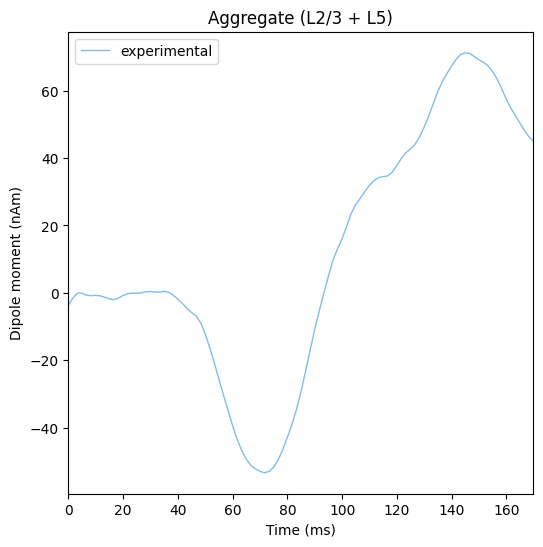

In [3]:
data_url = ('https://raw.githubusercontent.com/jonescompneurolab/hnn/master/'
            'data/MEG_detection_data/yes_trial_S1_ERP_all_avg.txt')
urlretrieve(data_url, 'yes_trial_S1_ERP_all_avg.txt')
dipole_experimental = read_dipole('yes_trial_S1_ERP_all_avg.txt')

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:blue')
ax.legend(['experimental'])

## 3. Simulate initial dipole

Now, we'll simulate the initial dipole using a predefined set of parameters
we arrived to after some hand-tuning. This simulation will provide a baseline
to compare against the experimental data before optimization.



MPI will run 3 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/

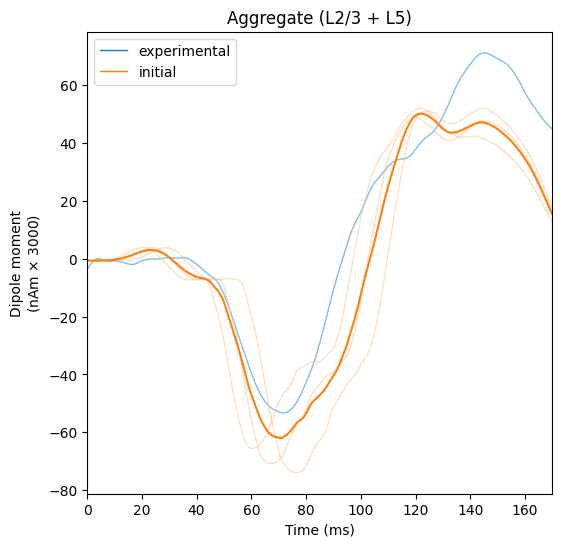

In [4]:
net_initial = jones_2009_model()

n_drive_cells = 1
cell_specific = False

# Proximal 1
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
synaptic_delays_p = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1., 'L5_pyramidal': 1.}
net_initial.add_evoked_drive('evprox1',
                             mu=26.61,
                             sigma=2.47,
                             numspikes=1,
                             location='proximal',
                             weights_ampa=weights_ampa_p1,
                             synaptic_delays=synaptic_delays_p,
                             n_drive_cells=n_drive_cells,
                             cell_specific=cell_specific)

# Distal
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net_initial.add_evoked_drive('evdist1',
                             mu=63.53,
                             sigma=3.85,
                             numspikes=1,
                             location='distal',
                             weights_ampa=weights_ampa_d1,
                             weights_nmda=weights_nmda_d1,
                             synaptic_delays=synaptic_delays_d1,
                             n_drive_cells=n_drive_cells,
                             cell_specific=cell_specific)

# Proximal 2
weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.1}
net_initial.add_evoked_drive('evprox2',
                             mu=120.,
                             sigma=1.,
                             numspikes=1,
                             location='proximal',
                             weights_ampa=weights_ampa_p2,
                             synaptic_delays=synaptic_delays_p,
                             n_drive_cells=n_drive_cells,
                             cell_specific=cell_specific)

# Simulate initial dipole
n_trials = 3
tstop = dipole_experimental.times[-1]
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    dipoles_initial = simulate_dipole(
        net_initial, tstop=tstop, n_trials=n_trials)

# Smooth and scale
window_length = 30
scaling_factor = 3000
for dipole in dipoles_initial:
    dipole.smooth(window_length).scale(scaling_factor)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:blue')
plot_dipole(dipoles_initial.copy(), ax=ax, layer='agg', show=False,
            color='tab:orange', average=True)

# Legend
legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.0),
                  Line2D([0], [0], color='tab:orange', lw=1.0)]
ax.legend(legend_handles, ['experimental', 'initial'])

## 4. Define the ``set_params`` function

Now we can begin the optimization!

First, we'll define a ``set_params`` function. This function tells the optimizer
how to apply the chosen parameters to the network during each iteration.

Comparison of the initial dipoles reveals that the second positive peak of the
experimental dipole (blue) has a larger amplitude, later latency, and broader
temporal distribution than the corresponding peak in the initial dipole (orange).

Let's optimize the relevant parameters for the second proximal (evprox2) drive,
as it is primarily responsible for this component of the dipole.



In [5]:
def set_params(net, params):

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=26.61,
                         sigma=2.47,
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         synaptic_delays=synaptic_delays_p,
                         n_drive_cells=n_drive_cells,
                         cell_specific=cell_specific)

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=63.53,
                         sigma=3.85,
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1,
                         n_drive_cells=n_drive_cells,
                         cell_specific=cell_specific)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                       'L5_basket': 0.008958, 'L5_pyramidal': params['evprox2_ampa_L5_pyramidal']}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         synaptic_delays=synaptic_delays_p,
                         n_drive_cells=n_drive_cells,
                         cell_specific=cell_specific)

## 5. Define optimization constraints

The constraints define the permissible range (lower and upper bounds) for each
parameter during the optimization process.

The ranges for synaptic weights (µS) are set to maintain physiologically
realistic model behavior, rather than solely relying on existing literature values.



In [6]:
constraints = dict({'evprox2_ampa_L5_pyramidal': (0.01, 1.0),
                    'evprox2_mu': (100., 150.),
                    'evprox2_sigma': (1., 20.)})

## 6. Define the initial parameters

For optimal results, set initial_params to your hand-tuned values since they
already provide a good fit.

If ``initial_params`` is not set, the optimizer will use the midpoint of the
constraints as the initial parameters.



In [7]:
initial_params = dict({'evprox2_ampa_L5_pyramidal': 0.1,
                       'evprox2_mu': 120.,
                       'evprox2_sigma': 1.})

## 7. Initialize and run the optimizer

Finally, let's initialize and run the optimizer. We'll instantiate the Optimizer
class, providing our network, simulation time, constraints, and the ``set_params``
function.

By default, the Optimizer aims to minimize the Root Mean Square Error (RMSE)
between the simulated and experimental dipoles.

To capture the model's average behavior, it's recommended to set ``n_trials``
to a value greater than 1. Using ``n_trials=1`` might find a parameter set that
works well for a single, specific simulation run but performs poorly on average.

Additionally, while ``max_iter`` is set to 50 in this example for a quicker
demonstration, you can set it to any value. The default is 200.

<div class="alert alert-info"><h4>Note</h4><p>A custom objective function can also be supplied.</p></div>



In [8]:
net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints,
                  set_params=set_params, initial_params=initial_params, max_iter=50)
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    optim.fit(target=dipole_experimental, n_trials=n_trials, scale_factor=scaling_factor,
              smooth_window_len=window_length)

MPI will run 3 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/

## 8. Simulate the optimized dipole

Now, we can simulate the dipole using the newly found optimized parameters
to see how well they match the experimental data.



In [9]:
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    dipoles_optimized = simulate_dipole(
        optim.net_, tstop=tstop, n_trials=n_trials)

# Smooth and scale
for dipole in dipoles_optimized:
    dipole.smooth(window_length).scale(scaling_factor)

MPI will run 3 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/

## 9. Visualize the results

Finally, we can compare the experimental, initial, and optimized dipoles.

We can also plot the convergence.



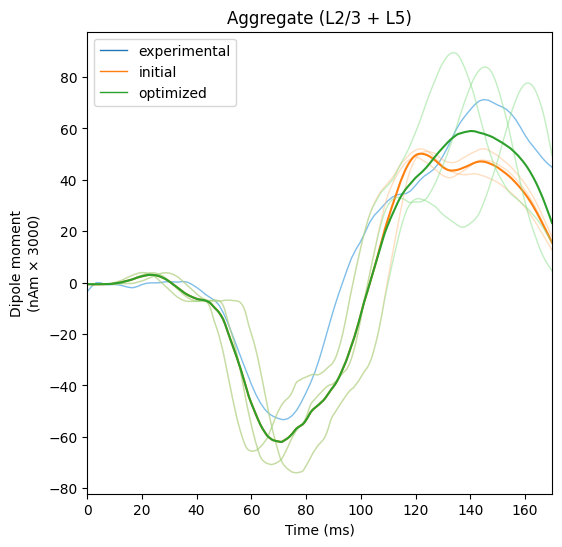

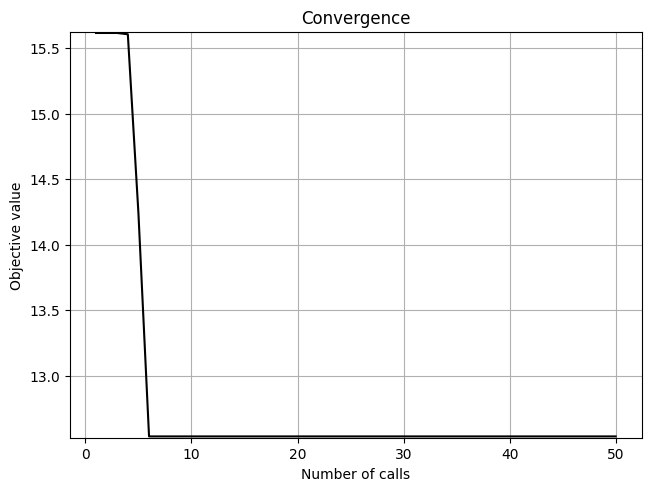

In [10]:
fig, ax = plt.subplots(sharex=True, figsize=(6, 6))
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:blue')
plot_dipole(dipoles_initial.copy(), ax=ax, layer='agg', show=False,
            color='tab:orange', average=True)
plot_dipole(dipoles_optimized.copy(), ax=ax, layer='agg',
            show=False, color='tab:green', average=True)

# Legend
legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.0),
                  Line2D([0], [0], color='tab:orange', lw=1.0),
                  Line2D([0], [0], color='tab:green', lw=1.0)]
ax.legend(legend_handles, ['experimental', 'initial', 'optimized'])

# Convergence plot
optim.plot_convergence()
plt.show()